
## Monte Carlo VaR and Expected Shortfall (ES) with Hull–White Model

### 1. Hull–White Short‑Rate Dynamics  
The short rate \(r_t\) follows  
$$
dr_t \;=\; \lambda\bigl(\theta(t)-r_t\bigr)\,dt \;+\; \eta\,dW_t
$$  
where  
- \(\lambda\) is the mean‑reversion speed  
- \(\theta(t)\) ensures calibration to today’s zero curve  
- \(\eta\) is the short‑rate volatility  

**Connection to Quant Finance**  
Calibration of \(\lambda,\eta,\theta\) to market cap/floor volatilities is standard in interest‑rate risk modeling.

**Nitish Sir (Hinglish Explanation)**  
“Yahan HW model se \(r_t\) simulate karte hain—\(\lambda\) jaldi revert karega curve pe, \(\eta\) vol control karta hai.”

---

### 2. Euler‑Maruyama Path Generation  
Discretize over \(\Delta t = T/N\):  
$$
r_{t+\Delta t} \;=\; r_t + \lambda(\theta(t)-r_t)\,\Delta t + \eta\sqrt{\Delta t}\,\xi_t,\quad \xi_t\sim N(0,1)
$$  
Generate \(N_{\text{paths}}\times N_{\text{steps}}\) paths to obtain matrix \(r_{i,j}\).

**Connection to Quant Finance**  
Monte Carlo paths underpin VaR/ES calculation for regulatory and internal risk metrics.

**Nitish Sir (Hinglish Explanation)**  
“Euler scheme se discrete steps mein \(r_t\) update karte hain, each \(\xi\) se randomness aati hai.”

---

### 3. Portfolio P&L Definition  
Define profit‑and‑loss at horizon \(\Delta t\) via change in portfolio value:  
$$
\mathrm{P\&L}_i = V\bigl(r_{i}(t+\Delta t)\bigr) \;-\; V\bigl(r_{i}(t)\bigr)
$$  
where \(V(r)\) is obtained from the `Portfolio` function summing multiple swap prices.

**Connection to Quant Finance**  
P&L distributions drive risk measures; the portfolio can include swaps, options, and other IR instruments.

**Nitish Sir (Hinglish Explanation)**  
“Har path pe portfolio value nikal ke P&L milta hai—yeh distribution VaR/ES ke liye chahiye.”

---

### 4. Value‑at‑Risk (VaR)  
For confidence level \(\alpha\), VaR is the lower \(\alpha\)-quantile of losses:  
$$
\mathrm{VaR}_\alpha \;=\; \inf\{\,x : F_{\mathrm{P\&L}}(x)\ge \alpha\}
$$  
In code:  
```python
VaR_estimate = np.quantile(PnL_vec, \alpha)
```

**Connection to Quant Finance**  
VaR is a standard market‑risk metric under Basel III and in internal risk reports.

**Nitish Sir (Hinglish Explanation)**  
“VaR_α nikalne ke liye sorted P&L vector mein se α-th percentile find karte hain—5% level pe worst-case loss.”

---

### 5. Expected Shortfall (ES)  
Also known as Conditional VaR, ES is the average loss beyond VaR:  
$$
\mathrm{ES}_\alpha 
= \mathbb{E}\bigl[\mathrm{P\&L} \mid \mathrm{P\&L}\le \mathrm{VaR}_\alpha\bigr]
\;=\;
\frac{1}{\alpha}\int_{-\infty}^{\mathrm{VaR}_\alpha} x\,dF_{\mathrm{P\&L}}(x)
$$  
In code:  
```python
tail_losses = PnL_vec[PnL_vec < VaR_estimate]
ES = np.mean(tail_losses)
```

**Connection to Quant Finance**  
ES is mandated by Basel IV for market‑risk capital as it captures tail risk better than VaR.

**Nitish Sir (Hinglish Explanation)**  
“VaR ke aage jitni losses hain unka average nikaalo—thati ES deta hai, tail-risk ko achhi tarah measure karta hai.”

---

### 6. Visualization  
- **Histogram** of P&L distribution  
- Markers for VaR and ES on the histogram  

This helps communicate risk to stakeholders and validate the tail behavior visually.

---

```  
# End of Markdown Theory Block  
```

Value V(t_0)=  [109336.29427367]
(H)VaR for alpha =  0.05  is equal to= -29015.929657420445
P&L which < VaR_alpha = [ -44206.32362513  -30570.25556162 -125351.72217845 ...  -57045.78829499
  -35292.89583253  -36334.38152011]
Expected shortfal =  -60797.60017181231


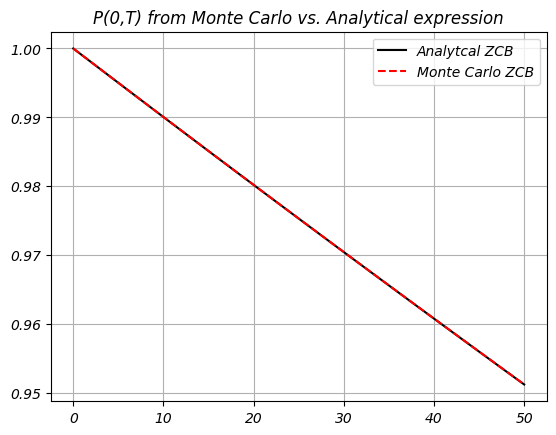

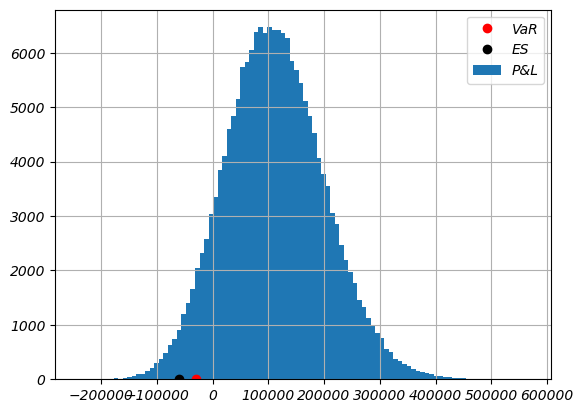

In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.optimize as optimize


# This class defines puts and calls
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)

    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0 / lambd * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + eta * eta / (
                2.0 * lambd * lambd) * (1.0 - np.exp(-2.0 * lambd * t))

    # theta = lambda t: 0.1 +t -t
    # print("changed theta")

    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    R = np.zeros([NoOfPaths, NoOfSteps + 1])
    R[:, 0] = r0
    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        R[:, i + 1] = R[:, i] + lambd * (theta(time[i]) - R[:, i]) * dt + eta * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt

    # Outputs
    paths = {"time": time, "R": R}
    return paths


def HW_theta(lambd, eta, P0T):
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    theta = lambda t: 1.0 / lambd * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + eta * eta / (
                2.0 * lambd * lambd) * (1.0 - np.exp(-2.0 * lambd * t))
    # print("CHANGED THETA")
    return theta  # lambda t: 0.1+t-t


def HW_A(lambd, eta, P0T, T1, T2):
    tau = T2 - T1
    zGrid = np.linspace(0.0, tau, 250)
    B_r = lambda tau: 1.0 / lambd * (np.exp(-lambd * tau) - 1.0)
    theta = HW_theta(lambd, eta, P0T)
    temp1 = lambd * np.trapz(theta(T2 - zGrid) * B_r(zGrid), zGrid)

    temp2 = eta * eta / (4.0 * np.power(lambd, 3.0)) * (
                np.exp(-2.0 * lambd * tau) * (4 * np.exp(lambd * tau) - 1.0) - 3.0) + eta * eta * tau / (
                        2.0 * lambd * lambd)

    return temp1 + temp2


def HW_B(lambd, eta, T1, T2):
    return 1.0 / lambd * (np.exp(-lambd * (T2 - T1)) - 1.0)


def HW_ZCB(lambd, eta, P0T, T1, T2, rT1):
    n = np.size(rT1)

    if T1 < T2:
        B_r = HW_B(lambd, eta, T1, T2)
        A_r = HW_A(lambd, eta, P0T, T1, T2)
        return np.exp(A_r + B_r * rT1)
    else:
        return np.ones([n])


def HWMean_r(P0T, lambd, eta, T):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2.0 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 2500)
    temp = lambda z: theta(z) * np.exp(-lambd * (T - z))
    r_mean = r0 * np.exp(-lambd * T) + lambd * np.trapz(temp(zGrid), zGrid)
    return r_mean


def HW_r_0(P0T, lambd, eta):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0


def HW_Mu_FrwdMeasure(P0T, lambd, eta, T):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 500)

    theta_hat = lambda t, T: theta(t) + eta * eta / lambd * 1.0 / lambd * (np.exp(-lambd * (T - t)) - 1.0)

    temp = lambda z: theta_hat(z, T) * np.exp(-lambd * (T - z))

    r_mean = r0 * np.exp(-lambd * T) + lambd * np.trapz(temp(zGrid), zGrid)

    return r_mean


def HWVar_r(lambd, eta, T):
    return eta * eta / (2.0 * lambd) * (1.0 - np.exp(-2.0 * lambd * T))


def HWDensity(P0T, lambd, eta, T):
    r_mean = HWMean_r(P0T, lambd, eta, T)
    r_var = HWVar_r(lambd, eta, T)
    return lambda x: stats.norm.pdf(x, r_mean, np.sqrt(r_var))


def HW_SwapPrice(CP, notional, K, t, Ti, Tm, n, r_t, P0T, lambd, eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid = np.array([Ti, Tm])
    else:
        ti_grid = np.linspace(Ti, Tm, n)
    tau = ti_grid[1] - ti_grid[0]

    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid < t)]
    if np.size(prevTi) > 0:  # prevTi != []:
        Ti = prevTi[-1]

    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid > t)]

    temp = np.zeros(np.size(r_t));

    P_t_TiLambda = lambda Ti: HW_ZCB(lambd, eta, P0T, t, Ti, r_t)

    for (idx, ti) in enumerate(ti_grid):
        if ti > Ti:
            temp = temp + tau * P_t_TiLambda(ti)

    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)

    if CP == OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP == OptionTypeSwap.RECEIVER:
        swap = K * temp - (P_t_Ti - P_t_Tm)

    return swap * notional


def Portfolio(P0T, r_t, lambd, eta):
    # IRSwap(CP,           notional,          K,   t,   Ti,  Tm,   n,      P0T):
    value = HW_SwapPrice(OptionTypeSwap.RECEIVER, 1000000, 0.02, 0.0, 0.0, 20, 20, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.PAYER, 500000, 0.01, 0.0, 0.0, 10, 20, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.RECEIVER, 25000, 0.02, 0.0, 0.0, 30, 60, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.PAYER, 74000, 0.005, 0.0, 0.0, 5, 10, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.RECEIVER, 254000, 0.032, 0.0, 0.0, 15, 10, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.RECEIVER, 854000, 0.01, 0.0, 0.0, 7, 20, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.PAYER, 900000, 0.045, 0.0, 0.0, 10, 20, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.PAYER, 400000, 0.02, 0.0, 0.0, 10, 20, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.RECEIVER, 1000000, 0.01, 0.0, 0.0, 14, 20, r_t, P0T, lambd, eta) + \
            HW_SwapPrice(OptionTypeSwap.PAYER, 115000, 0.06, 0.0, 0.0, 9, 10, r_t, P0T, lambd, eta)
    # HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,P0T,lambd,eta)
    return value


def mainCalculation():
    NoOfPaths = 2000
    NoOfSteps = 100
    lambd = 0.5
    eta = 0.03

    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.001 * T)
    r0 = HW_r_0(P0T, lambd, eta)

    # In this experiment we compare ZCB from the Market and Analytical expression
    N = 25
    T_end = 50
    Tgrid = np.linspace(0, T_end, N)

    Exact = np.zeros([N, 1])
    Proxy = np.zeros([N, 1])
    for i, Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd, eta, P0T, 0.0, Ti, r0)
        Exact[i] = P0T(Ti)

    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid, Exact, '-k')
    plt.plot(Tgrid, Proxy, '--r')
    plt.legend(["Analytcal ZCB", "Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')

    T_end = 20
    paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T_end, P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1] - timeGrid[0]

    M_t = np.zeros([NoOfPaths, NoOfSteps])

    for i in range(0, NoOfPaths):
        M_t[i, :] = np.exp(np.cumsum(r[i, 0:-1]) * dt)

    r0 = r[0, 0]
    stepSize = 10
    V_M = np.zeros([NoOfPaths, NoOfSteps - stepSize])

    for i in range(0, NoOfSteps - stepSize):
        dr = r[:, i + stepSize] - r[:, i]
        V_t0 = Portfolio(P0T, r[:, 0] + dr, lambd, eta)
        V_M[:, i] = V_t0
    plt.figure(2)
    V_t0_vec = np.matrix.flatten(V_M)
    plt.hist(V_t0_vec, 100)
    plt.grid()

    print('Value V(t_0)= ', Portfolio(P0T, r[0, 0], lambd, eta))

    alpha = 0.05
    HVaR_estimate = np.quantile(V_t0_vec, alpha)
    print('(H)VaR for alpha = ', alpha, ' is equal to=', HVaR_estimate)

    # Expected shortfal
    condLosses = V_t0_vec[V_t0_vec < HVaR_estimate]
    print('P&L which < VaR_alpha =', condLosses)
    ES = np.mean(condLosses)
    print('Expected shortfal = ', ES)

    plt.plot(HVaR_estimate, 0, 'or')
    plt.plot(ES, 0, 'ok')
    plt.legend(['VaR', 'ES', 'P&L'])


mainCalculation()




